Neste código eu crio um catálogo aleatório a partir da função de densidade de redshift do catálogo do BOSS e utilizo ele para calcular a função de correlação.

In [1]:
from astropy.io import fits
import sys
sys.path.append('../2PCF/Functions')

#bibliotecas necessárias para a função cf_smu
import numpy as np
import pandas as pd
import time 
from Corrfunc.mocks.DDsmu_mocks import DDsmu_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
from astropy.cosmology import FlatLambdaCDM as FLCDM


import matplotlib.pyplot as plt
import cf_tools as cf
import corrfunc_tools

In [2]:
# https://arxiv.org/pdf/1607.03148.pdf

c  = 299792458/1000
zmin, zmax = 0.1, 0.6

In [3]:
# https://docs.astropy.org/en/stable/io/fits/index.html

# Galaxies

hdul = fits.open("galaxy_DR12v5_CMASSLOWZE2_North.fits")
hdul.verify('fix')
data = hdul[1].data
# print(data.columns)
hdul.close()

ra0  = data['RA']
dec0 = data['DEC']
z0   = data['Z']


sel = (z0 > zmin) & (z0 < zmax)
ra, dec, z = ra0[sel], dec0[sel], z0[sel]

In [4]:
raminmax  = [ra.min(), ra.max()]
decminmax = [dec.min(), dec.max()]

print(raminmax)
print(decminmax)

[108.93713069095938, 263.90750667151144]
[-3.6281203026551636, 68.73769854149388]


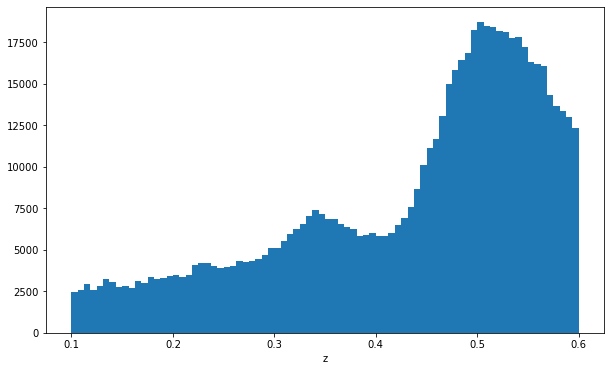

In [5]:
counts, bins = np.histogram(z, bins = 80)

plt.subplots(figsize = (10, 6))
plt.hist(z, bins = 80)
plt.xlabel('z')
plt.show()

In [6]:
def make_randoms(bins, counts, Nr, raminmax, decminmax): 
    # set cosmology
    h=0.6774
    cosmo=FLCDM(100*h,0.3089)

    # binedge = np.append(bins-dbin/2, bins[-1]+dbin/2)
    # dbin = bins[1]-bins[0]
    norm = np.sum(counts)
    normalized = counts/norm
    total_por_bin = normalized*Nr 

    random_z = np.array([])
    i = 0
    for el in total_por_bin:
        dbin = bins[i+1]-bins[i]
        #I'm not quite sure about the line bellow...
        u = (np.random.uniform(0,1,int(round(el))))
        binrand = u*dbin + bins[i]
        random_z = np.append(random_z, binrand)
        i+=1

    #Nr_new is necessary as upon normalization of bincounts, a number of randoms different from Nr may be generated
    Nr_new = len(random_z) 
    cosminmax = [np.cos(decminmax[0]*np.pi/180), np.cos(decminmax[1]*np.pi/180)]
    costheta = np.random.uniform(cosminmax[1],cosminmax[0],Nr_new)
    
    rar  = np.random.uniform(raminmax[0],raminmax[1],Nr_new)
    decr = np.arccos(costheta)*180/np.pi
    
    return rar, decr, random_z


In [7]:
rar, decr, zr = make_randoms(bins, counts, Nr = len(z)*3, raminmax = raminmax, decminmax = decminmax)

radecr1 = np.array([ra, dec, c*z]).T
radecr2 = np.array([rar, decr, c*zr]).T

In [8]:
binfile = corrfunc_tools.make_logbins(40, 160, 24)

mubin, cfunc = corrfunc_tools.cf_smu(radecr1, radecr2, binfile, nthreads = 4) 

	 Tempo DD =  3.6036198139190674 s
	 Tempo RR =  39.51032209396362 s
	 Tempo DR =  21.174241304397583 s


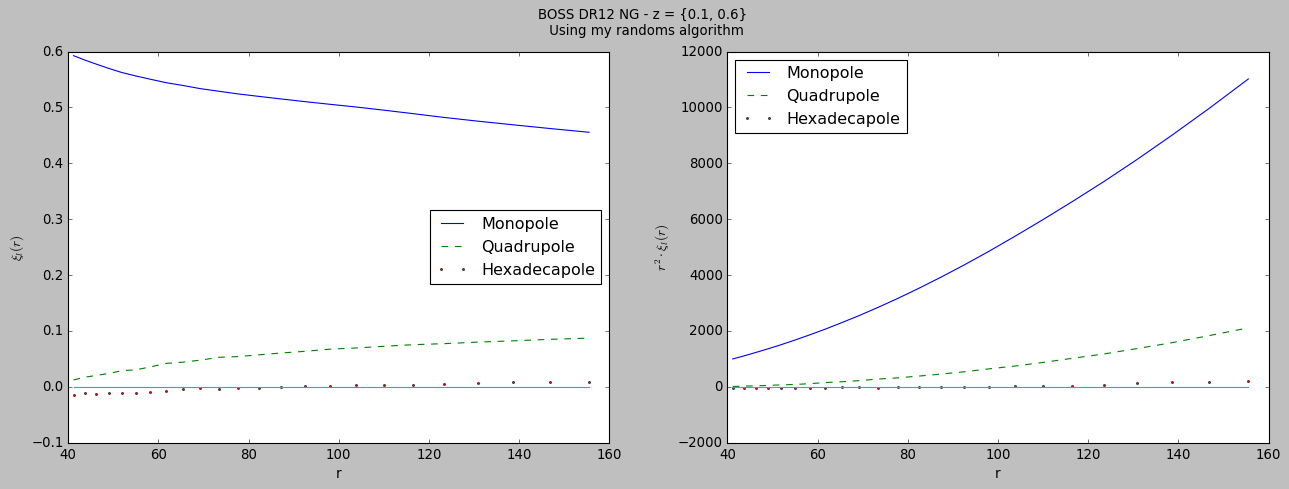

In [9]:
r = binfile
rmin, rmax = 40, 160
x=(r[:-1]+r[1:])/2
mubincenter = (mubin[:-1] + mubin[1:])/2
xi_0, xi_2, xi_4 = cf.multipoles_trapz(mubin, cfunc)

#################################### make plot ####################################
#plot the multipoles
plt.style.use('classic')

#first plot
fig=plt.figure(figsize=(16, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 2, left=0.05, right=0.5, wspace=0.05)

ax1 = fig.add_subplot(gs[0,0])
ax1.set_xlim(rmin,rmax)
ax1.plot(x,xi_0,'-',x,xi_2,'--',x,xi_4,'o',markersize=1.9)
ax1.set_xlabel("r")
ax1.set_ylabel(r"$\xi_l(r)$")

ax2 = fig.add_subplot(gs[0,1])
ax2.set_xlim(rmin,rmax)
ax2.plot(x,x**2*xi_0,'-',x,x**2*xi_2,'--',x,x**2*xi_4,'o',markersize=1.9)
ax2.set_xlabel("r")
ax2.set_ylabel(r"$r^2 \cdot \xi_l(r)$")

ax1.legend(["Monopole","Quadrupole","Hexadecapole"],loc='best')
ax2.legend(["Monopole","Quadrupole","Hexadecapole"],loc='best')

hor = [0]*len(x) 
ax1.plot(x,hor)
ax2.plot(x,hor)

plt.rcParams.update({'font.size': 12})
fig.suptitle('BOSS DR12 NG - z = {' + str(zmin) + ', ' + str(zmax) + '} \n Using my randoms algorithm')

plt.show()

In [10]:
# fig.savefig('BOSSDR12_NG-z0106_myrandoms.pdf')

# Sky Coverage

In [ ]:

import healpy as hp
import sys

footprint_res = 256

def plot_delta(ang1, ang2, radec=False, footprint=None, radians=False):

    # conversion to radians if needed
    if radians:
        conv=1.
    else:
        conv=np.pi/180.
        ang1 *= conv
        ang2 *= conv

    # check that angles are correct
    if radec:
        # ang1 is ra and must be between 0 and 2pi
        if (np.min(ang1)<0) | (np.max(ang1)>2.*np.pi):
            print("ang 1 should be ra, but it does not stay between 0 and 2pi")
            return None
        # ang2 is dec and must be between -pi/2 and pi/2
        if (np.min(ang2)<-np.pi/2.) | (np.max(ang1)>np.pi/2.):
            print("ang 2 should be dec, but it does not stay between -pi/2 and pi/2")
            return None
    else:
        # ang1 is theta and must be between 0 and pi
        if (np.min(ang1)<0) | (np.max(ang1)>np.pi):
            print("ang 1 should be theta, but it does not stay between 0 and pi")
            return None
        # ang2 is phi and must be between -pi and pi
        if (np.min(ang2)<-np.pi) | (np.max(ang1)>np.pi):
            print("ang 2 should be phi, but it does not stay between 0 and 2pi")
            return None

    # pixels for galaxies
    if radec:
        pix = hp.ang2pix(footprint_res, np.pi/2. - ang2, ang1)
    else:
        pix = hp.ang2pix(footprint_res, ang1, ang2)

    # density
    delta=np.zeros(hp.nside2npix(footprint_res),dtype=np.float)
    for this in pix:
        delta[this]+=1.0

    # if footprint is not None:
    #     av = np.mean(delta[footprint])
    #     delta = (delta-av)/av
    #     delta[~footprint] = hp.UNSEEN
    # else:
    #     av = np.mean(delta)
    #     delta = (delta-av)/av

    hp.mollview(delta)
    hp.orthview(delta,rot=[0,90,0])

    